In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import math
from pcygni_9 import PcygniCalculator
from scipy.interpolate import interp1d
import astropy.units as units
import astropy.constants as csts
import time
import corner

pi = np.pi; h = 6.626e-34; c = 3.0e+8; k = 1.38e-23

#My plot style to standardize my plot esthetics
def reset_plt(ticksize,fontsize):
    plt.style.use('seaborn-white')
    plt.rcParams['xtick.labelsize'] = ticksize
    plt.rcParams['ytick.labelsize'] = ticksize
    plt.rcParams['font.size'] = fontsize
    plt.rcParams['mathtext.fontset'] = 'stix'
    plt.rcParams['font.family'] = 'STIXGeneral'
    plt.rcParams['legend.facecolor'] = 'white'
    plt.rcParams['axes.formatter.limits'] = (-1,3)
    plt.rcParams['axes.linewidth'] = 2.25
    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.6
    #plt.rcParams['pcolor.shading'] = 'nearest'
    

def put_ticks(this_fig,this_ax):
    this_ax.xaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'major', direction = 'in', width = 2.5, length = 12, zorder = 1, right = True)
    this_ax.xaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, top = True)
    this_ax.yaxis.set_tick_params(which = 'minor', direction = 'in', width = 1.5, length = 6, zorder = 1, right = True)
    dx = -3/72
    dy = -3/72
    y_offset = matplotlib.transforms.ScaledTranslation(0, dy, this_fig.dpi_scale_trans)
    x_offset = matplotlib.transforms.ScaledTranslation(dx, 0, this_fig.dpi_scale_trans)

    for label in this_ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + y_offset)

    for label in this_ax.yaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + x_offset)
        

In [13]:
from astropy.modeling import models
import numba

def bb(wav, T, N):
    wav = wav
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5)*(math.e**b - 1.0) )
    return N*intensity

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, ratio_vel = 1, t0 = 120960): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA, ratio_vel = ratio_vel)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=25 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)

@numba.njit(fastmath=True)
def temp(wav,T):
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    return a/ ( (wav**5)*(np.exp(b) - 1.0) )
    
@numba.njit(fastmath=True)
def gaussian(wav, amp, mu, sigma): 
    return amp*np.exp(-(wav-mu)**2/(2*sigma**2))
    
from astropy.modeling import models

def p_cygni_line_corr(wl, v_out, v_phot, tau, lam, vref=0.2, ve=0.2, ratio_vel = 1, t0 = 120960, theta_inc=21): 
    prof_calc = PcygniCalculator(t=t0 * units.s, vmax=v_out * csts.c,
                                 vphot=v_phot * csts.c, tauref=tau, vref=vref *
                                 csts.c, ve=ve * csts.c,
                                 lam0=lam * units.AA, ratio_vel = ratio_vel, theta_inc=theta_inc)#, _lam_min=7000, _lam_max=13000)
    
    cyg = prof_calc.calc_profile_Flam( npoints=40 )  
    
    inter = interp1d(cyg[0].value*1e-10, cyg[1], bounds_error=False, fill_value=1)    
    return inter(wl)


def residual(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult2 = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    ratio_vel = v["ratio_vel"]
    theta_inc = v["inclin"]
    
    model = planck_with_mod(wav, T, N, vmax, vphot, tau=tau, occul=occult2, ve = ve, vref = vref, 
                           amp1 = amp1, cen1=cen1, sig1=sig1, amp2 = amp2, cen2=cen2, sig2=sig2, ratio_vel=ratio_vel, theta_inc=theta_inc)
    
    if data is None:
        return model
    return (model - data)/error

def residual_p_cygni(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    #amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    ratio_vel = v["ratio_vel"]; theta_inc = v["inclin"]

    
    intensity = np.ones_like(wav)
    
    pcyg_prof3 = p_cygni_line_corr(wav, vmax, vphot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    pcyg_prof4 = p_cygni_line_corr(wav, vmax, vphot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    pcyg_prof5 = p_cygni_line_corr(wav, vmax, vphot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occult + 1
    
    intensity = N*intensity*(correction)
    
    if data is None:
        return intensity
    return (model - data)/error

def residual_p_cygni_n(pars, wav, data=None, error=None): 
    v = pars.valuesdict()
    T, N, vphot = v["T"], v["N"], v["vphot"]
    t0, vmax, tau, vref, ve, occult = v["t0"], v["vmax"], v["tau"], v["vref"], v["ve"], v["occult"]
    #amp1, amp2, cen1, cen2, sig1, sig2= v["amp1"], v["amp2"], v["cen1"], v["cen2"], v["sig1"], v["sig2"]

    ratio_vel = v["ratio_vel"]; theta_inc = v["inclin"]

    
    intensity = np.ones_like(temp(wav, T))
    
    pcyg_profn = p_cygni_line_corr(wav, vmax, vphot, tau   , 10000, vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    #pcyg_prof3 = p_cygni_line_corr(wav, vmax, vphot, 1/13.8*tau   , 10036.65, vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    #pcyg_prof4 = p_cygni_line_corr(wav, vmax, vphot, 8.1/13.8*tau , 10327.311,vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    #pcyg_prof5 = p_cygni_line_corr(wav, vmax, vphot, 4.7/13.8*tau , 10914.887,vref=vref, ve=ve , t0=t0, ratio_vel=ratio_vel, theta_inc=theta_inc)
    correction = pcyg_profn#pcyg_prof3*pcyg_prof4*pcyg_prof5
    correction[correction>1] = (correction[correction>1]-1)*occult + 1
    
    intensity = N*intensity*(correction)
    
    if data is None:
        return intensity
    return (model - data)/error

def residual_p_cygni_dataframe(pars, wav, data=None, error=None): 
    v=pars
    vphot = v["vphot"].values[0]; 
    vmax, tau, ve, occult2 = v["vmax"].values[0], v["tau"].values[0], v["ve"].values[0], v["occult"].values[0]
    ratio_vel = v["ratio_vel"].values[0]; theta_inc = v["inclin"].values[0]

    
    intensity = np.ones_like(wav)
    v_out=vmax
    v_phot = vphot
    occul=occult2
    
    pcyg_prof3 = p_cygni_line_corr(wav, v_out, v_phot, 1/13.8*tau   , 10036.65, vref=0, ve=ve , ratio_vel=ratio_vel, theta_inc=theta_inc)
    pcyg_prof4 = p_cygni_line_corr(wav, v_out, v_phot, 8.1/13.8*tau , 10327.311,vref=0, ve=ve , ratio_vel=ratio_vel, theta_inc=theta_inc)
    pcyg_prof5 = p_cygni_line_corr(wav, v_out, v_phot, 4.7/13.8*tau , 10914.887,vref=0, ve=ve , ratio_vel=ratio_vel, theta_inc=theta_inc)
    correction = pcyg_prof3*pcyg_prof4*pcyg_prof5
    #correction[correction>1] = (correction[correction>1]-1)*occul + 1
    
    intensity = intensity*(correction)
    
    if data is None:
        return intensity
    return (model - data)/error

import lmfit

n_days = [1.427, 2.417, 3.413, 4.403]
fac = 1e16

In [53]:
p = lmfit.Parameters()
OB = 'OB1'
with open("./data/OB1_with_fixed_assym_freeinc_init.json", 'r') as infile:
    p.load(infile)
emcee_res=p   
p['occult'].value = 1
p['N'].value = 1
p['inclin'].value=21
p['ratio_vel'].value = 0.90
p['ve'].value = 1
p['ve'].max = 100

p['T'].vary=False; p['N'].vary=False; p['amp1'].vary=False; p['amp2'].vary=False
p['occult'].vary = True

In [54]:
#p['vphot'].value = 0.1
#p['vmax'].value = 0.4


In [55]:
p

Parameters([('T', <Parameter 'T', value=5436 (fixed), bounds=[2500:7500]>), ('N', <Parameter 'N', value=1 (fixed), bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.28, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.338, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=1.69, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=1, bounds=[0:100]>), ('occult', <Parameter 'occult', value=1, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.28 (fixed), bounds=[0:1]>), ('amp2', <Parameter 'amp2', value=0.44 (fixed), bounds=[0:1]>), ('cen1', <Parameter 'cen1', value=1.55e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=2.02e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=5.8e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=8e-08 (fixed), bounds=[1e-08:3e-07]>), ('ratio_vel', <Parameter 'ratio_vel', value=0.9, bounds=[0.8:1.2]>), ('inclin', <Parameter 'inclin', value=21, bounds=[0:90]>)])

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

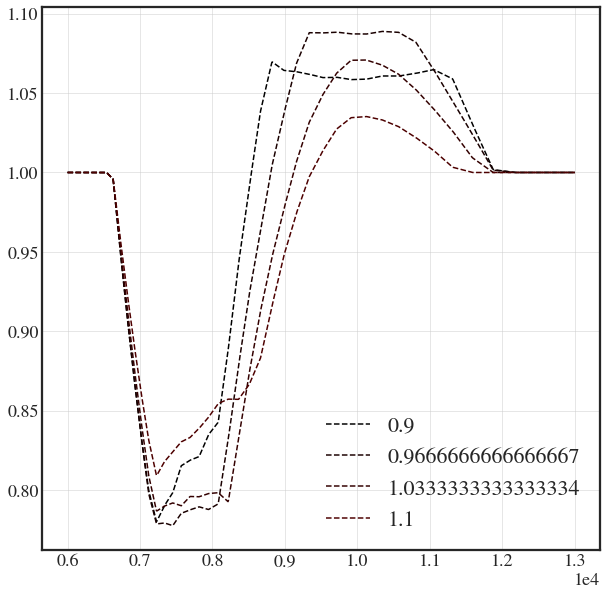

In [56]:
wl2 = np.linspace(6000, 13000, 1000)

plt.figure(figsize=(10,10))
for idx,ratio in enumerate(np.linspace(0.9, 1.1, 4)):
    p['inclin'].value = 0
    p['ratio_vel'].value = ratio
    flux_fit2 = residual_p_cygni_n(p, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', color=[idx/10, 0, 0], label=str(ratio))#, color='red')
    
plt.legend()


C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

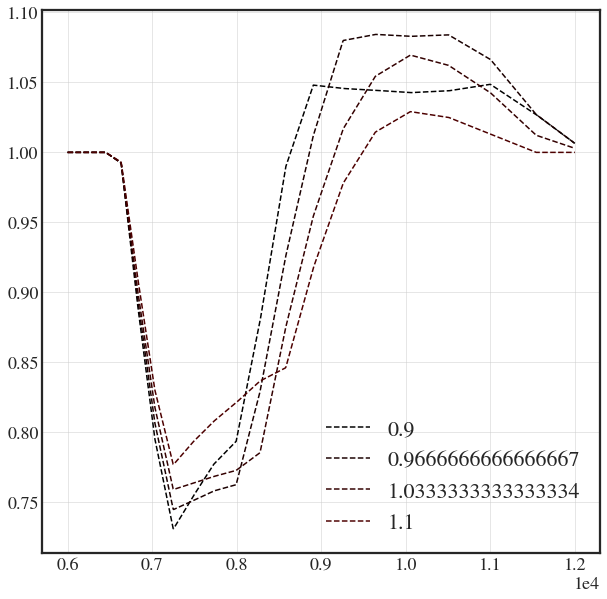

In [35]:
wl2 = np.linspace(6000, 12000, 1000)

plt.figure(figsize=(10,10))
for idx,ratio in enumerate(np.linspace(0.9, 1.1, 4)):
    p['inclin'].value = 0
    p['ratio_vel'].value = ratio
    flux_fit2 = residual_p_cygni_n(p, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', color=[idx/10, 0, 0], label=str(ratio))#, color='red')
    
plt.legend()


C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

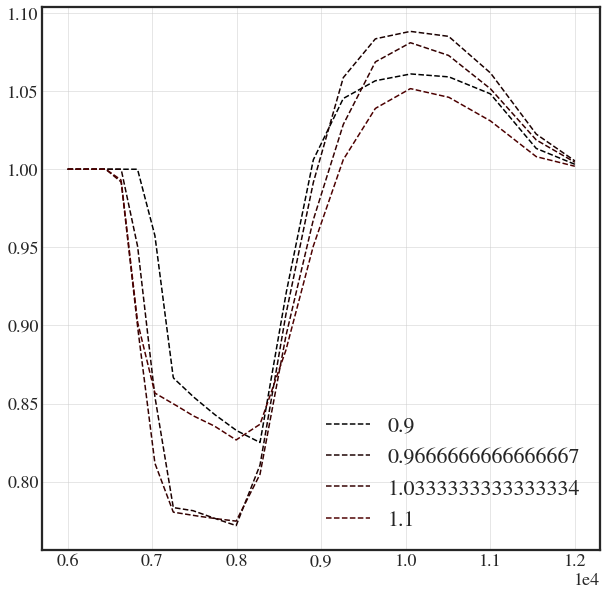

In [37]:
wl2 = np.linspace(6000, 12000, 1000)

plt.figure(figsize=(10,10))
for idx,ratio in enumerate(np.linspace(0.9, 1.1, 4)):
    p['inclin'].value = 90
    p['ratio_vel'].value = ratio
    flux_fit2 = residual_p_cygni_n(p, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', color=[idx/10, 0, 0], label=str(ratio))#, color='red')
    
plt.legend()


C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

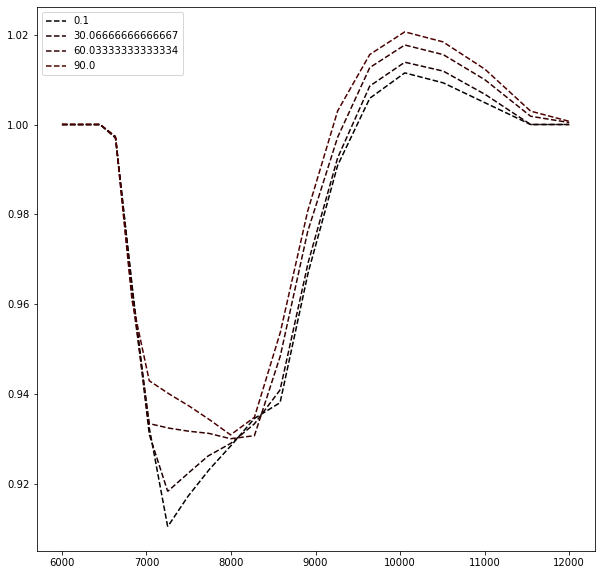

In [6]:
wl2 = np.linspace(6000, 12000, 1000)

plt.figure(figsize=(10,10))
for idx,ratio in enumerate(np.linspace(0.1, 90, 4)):
    p['ratio_vel'].value = 1.1
    p['inclin'].value = ratio
    flux_fit2 = residual_p_cygni_n(p, wl2*1e-10)
    plt.plot(wl2, flux_fit2, ls='--', color=[idx/10, 0, 0], label=str(ratio))#, color='red')
    
plt.legend()

In [26]:
np.linspace(0.9, 1.10, 6), np.linspace(0., 90, 6)

(array([0.9 , 0.94, 0.98, 1.02, 1.06, 1.1 ]),
 array([ 0., 18., 36., 54., 72., 90.]))

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

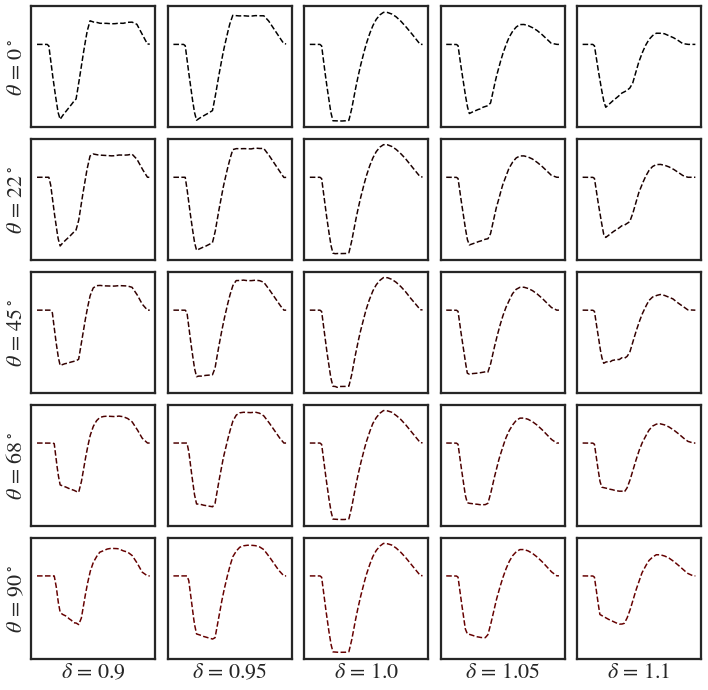

In [27]:
n = 5
reset_plt(18,22)

fig,ax = plt.subplots(figsize=(12,12), ncols=n, nrows=n, sharex=True, sharey=True  )
for idx,ratio in enumerate(np.linspace(0., 90, n)):
    for idx2,ratio2 in enumerate(np.linspace(0.901, 1.101, n)):
        p['ratio_vel'].value = ratio2
        p['inclin'].value = ratio
        flux_fit2 = residual_p_cygni_n(p, wl2*1e-10)
        
        ax[idx, idx2].plot(wl2, flux_fit2, ls='--', color=[idx/10, 0, 0], label=str(ratio))#, color='red')
        
        ax[idx,idx2].set_yticks([])
        ax[idx,idx2].set_xticks([])
        ax[n-1,idx2].set_xlabel(r'$\delta$ = '+str(round(ratio2*100)/100))
    ax[idx, 0].set_ylabel(r'$\theta$ = '+str(round(ratio))+'$^\circ$')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig('Pictures/theta_inclination_3.png', dpi=300)

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

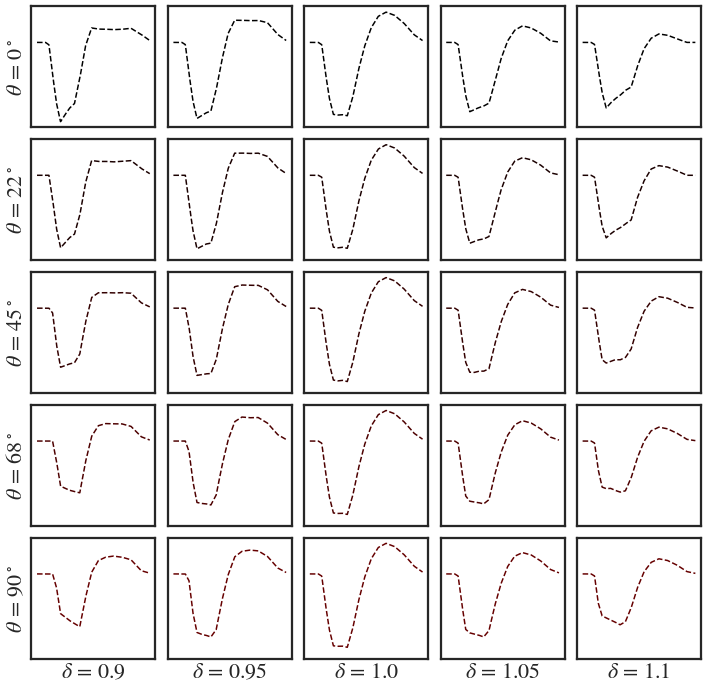

In [33]:
n = 5
reset_plt(18,22)

fig,ax = plt.subplots(figsize=(12,12), ncols=n, nrows=n, sharex=True, sharey=True  )
for idx,ratio in enumerate(np.linspace(0., 90, n)):
    for idx2,ratio2 in enumerate(np.linspace(0.901, 1.101, n)):
        p['ratio_vel'].value = ratio2
        p['inclin'].value = ratio
        flux_fit2 = residual_p_cygni_n(p, wl2*1e-10)
        
        ax[idx, idx2].plot(wl2, flux_fit2, ls='--', color=[idx/10, 0, 0], label=str(ratio))#, color='red')
        
        ax[idx,idx2].set_yticks([])
        ax[idx,idx2].set_xticks([])
        ax[n-1,idx2].set_xlabel(r'$\delta$ = '+str(round(ratio2*100)/100))
    ax[idx, 0].set_ylabel(r'$\theta$ = '+str(round(ratio))+'$^\circ$')
    
plt.subplots_adjust(wspace=0.1, hspace=0.1)

plt.savefig('Pictures/theta_inclination.png', dpi=300)

In [69]:
p = lmfit.Parameters()
OB = 'OB1'
with open("./data/OB1_with_fixed_assym_freeinc_init.json", 'r') as infile:
    p.load(infile)
emcee_res=p   
p['occult'].value = 1
p['N'].value = 1
p['inclin'].value=21
p['ratio_vel'].value = 1.1
p['ve'].value = 1
p['ve'].max = 100

p['T'].vary=False; p['N'].vary=False; p['amp1'].vary=False; p['amp2'].vary=False
p['occult'].vary = True


C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


Text(0, 0.5, '$\\theta$')

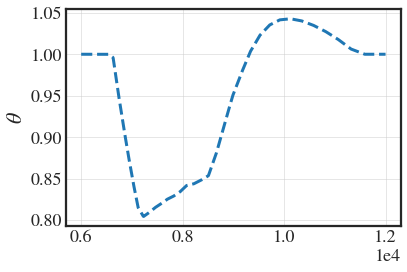

In [70]:
wl2 = np.linspace(6000, 12000, 1000)

p['tau'].value = 2
flux_fit2 = residual_p_cygni_n(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label='$v_{line, \perp}=0.95 \cdot v_{line,\parallel}$', linewidth=3)#, color='red')

plt.ylabel(r'$\theta$')

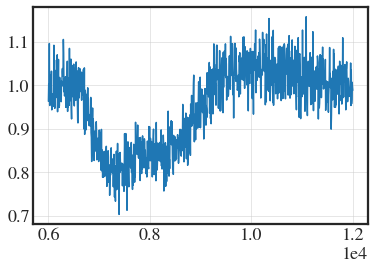

In [71]:
wl = wl2
flux = flux_fit2 * np.random.normal(loc=1, scale=0.04, size=len(flux_fit2) )
error = np.ones_like(flux)*0.04
plt.plot(wl, flux)

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


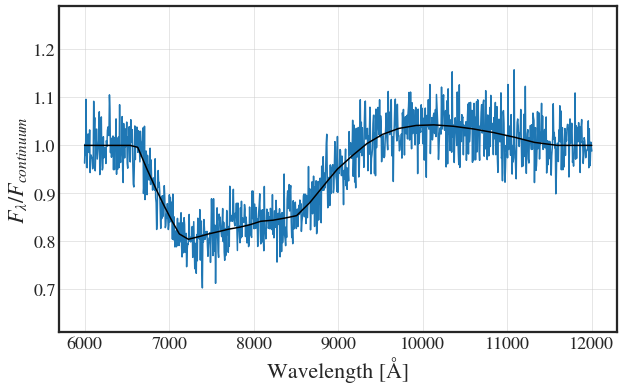

In [72]:
plt.figure(figsize=(10,6))
plt.plot(wl, flux)
#plt.savefig('Pictures/Simulated_angle_PCygni.png', dpi=300)

plt.plot(wl2, residual_p_cygni_n( p,  wl2*1e-10 ), alpha=1, color='k')

plt.ylabel(r'$F_{\lambda}/F_{continuum}$'), plt.ylim(0.61, 1.29)
plt.xlabel(r'Wavelength [Å]'), plt.ticklabel_format(useOffset=False, style='plain')
#params = res3.params
#plt.plot(wl2, residual_p_cygni( params,  wl2*1e-10 ), alpha=1, color='k', ls='--')


plt.savefig('Pictures/Simulated_angle_PCygni_wbestfit_2.png', dpi=300)

#for ind in inds:
##    pass#sample = flat[ind]
#print( ind)    


C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


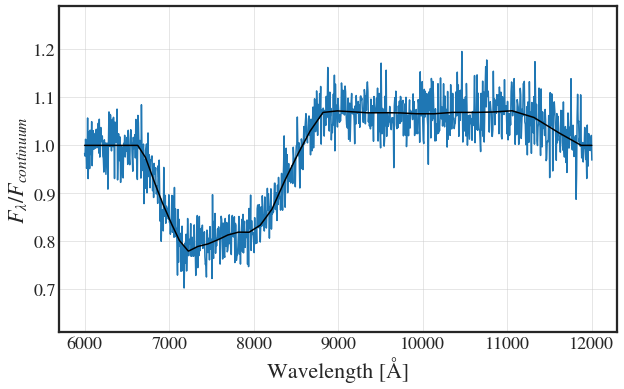

In [68]:
plt.figure(figsize=(10,6))
plt.plot(wl, flux)
#plt.savefig('Pictures/Simulated_angle_PCygni.png', dpi=300)

plt.plot(wl2, residual_p_cygni_n( p,  wl2*1e-10 ), alpha=1, color='k')

plt.ylabel(r'$F_{\lambda}/F_{continuum}$'), plt.ylim(0.61, 1.29)
plt.xlabel(r'Wavelength [Å]'), plt.ticklabel_format(useOffset=False, style='plain')
#params = res3.params
#plt.plot(wl2, residual_p_cygni( params,  wl2*1e-10 ), alpha=1, color='k', ls='--')


plt.savefig('Pictures/Simulated_angle_PCygni_wbestfit_1.png', dpi=300)

#for ind in inds:
##    pass#sample = flat[ind]
#print( ind)    


In [29]:
np.sum(((flux-residual_p_cygni_n( p,  wl2*1e-10 ))/error)**2)/len(flux)

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


0.9337162329796896

In [30]:
p2 = lmfit.Parameters()
#OB = 'OB1'
with open("./data/OB2_with_fixed_assym_free_inc.json", 'r') as infile:
    p2.load(infile)
p2

Parameters([('T', <Parameter 'T', value=3894.1653229879776, bounds=[2500:7500]>), ('N', <Parameter 'N', value=2.8896906673525256e-29, bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.24291716517227085, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.275220930760095, bounds=[0:1]>), ('t0', <Parameter 't0', value=212400 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=7.096566502438844, bounds=[0:20]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=0.1475090755589915, bounds=[0:2]>), ('occult', <Parameter 'occult', value=1.125620601285593, bounds=[0.1:10]>), ('amp1', <Parameter 'amp1', value=0.5788845920066874, bounds=[0.01:5]>), ('amp2', <Parameter 'amp2', value=0.5855783654402262, bounds=[0.01:5]>), ('cen1', <Parameter 'cen1', value=1.55e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=2.02e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=1.083e-07 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=7.42e-08 (fixed), bounds=[1e-08:3e-07]>), ('ratio_vel', <Parameter 'ratio_vel', value=0.998 (fixed), bounds=[0.8:1.2]>), ('inclin', <Parameter 'inclin', value=24.652686552480166, bounds=[0:90]>)])

In [31]:
@numba.njit(fastmath=True)
def lnprob_inner(model, flux, error):
    return -0.5 * np.sum(((model - flux) / error)**2 + np.log(2 * np.pi * error**2))

def lnprob(pars):
    """This is the log-likelihood probability for the sampling."""    
    model = residual_p_cygni_n(pars, wl*1e-10)
    return lnprob_inner(model, flux, error)

p

#p['inclin'].value=80
#p['ratio_vel'].value = 1.1
#p['occult'].value = 1.12

#p['vphot'].value = 0.24
#p['vmax'].value = 0.28
#p['ve'].value = 0.18
#p['tau'].value = 7

p

Parameters([('T', <Parameter 'T', value=5436 (fixed), bounds=[2500:7500]>), ('N', <Parameter 'N', value=1 (fixed), bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.28, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.338, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=2, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=1, bounds=[0:100]>), ('occult', <Parameter 'occult', value=1, bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.28 (fixed), bounds=[0:1]>), ('amp2', <Parameter 'amp2', value=0.44 (fixed), bounds=[0:1]>), ('cen1', <Parameter 'cen1', value=1.55e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=2.02e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=5.8e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=8e-08 (fixed), bounds=[1e-08:3e-07]>), ('ratio_vel', <Parameter 'ratio_vel', value=0.9, bounds=[0.8:1.2]>), ('inclin', <Parameter 'inclin', value=21, bounds=[0:90]>)])

In [36]:
mini = lmfit.Minimizer(lnprob, p) 

start = time.time()
nwalkers = 24 #v = p.valuesdict()
res6 = mini.emcee(nwalkers=nwalkers, burn=0, steps=2500, thin=1, params=p, seed=12345, workers = 4)
end = time.time()

print('Time elapsed [hours]:',(end-start)/60/60 )#wqeaaaaaaas

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
100%|██████████| 2500/2500 [8:23:33<00:00, 12.09s/it]  


The chain is shorter than 50 times the integrated autocorrelation time for 7 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 50;
tau: [127.71890802 121.3974528  280.92199697 284.44287521 142.95731599
 169.60548004 172.10703249]
Time elapsed [hours]: 8.395830276939604


7.135529204473835 18.242766924280325 22.931322809894386


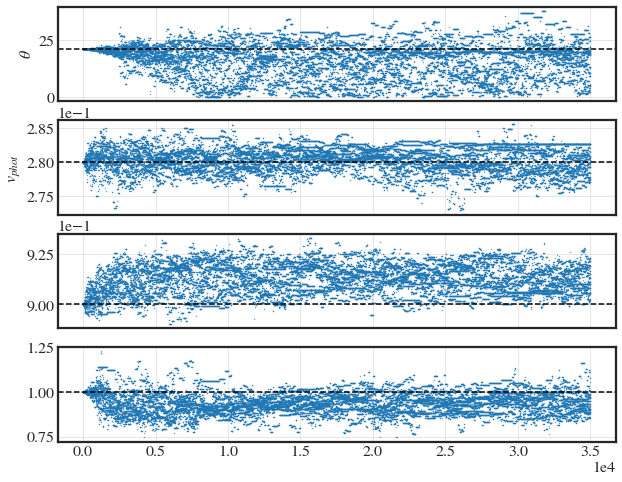

In [39]:
reset_plt(16,16)

flat2 = res5.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=4, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

ax[2].scatter(np.arange(len(flat2['inclin'])), flat2['ratio_vel'], s=0.1)
ax[2].axhline(0.9, ls='--', color='k')
#plt.ylim(0.75, 1.25)#ax[2].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{ratio}$')

ax[3].scatter(np.arange(len(flat2['inclin'])), flat2['occult'], s=0.1)
ax[3].axhline(1, ls='--', color='k')
#plt.xlim(0, 16*200*2)

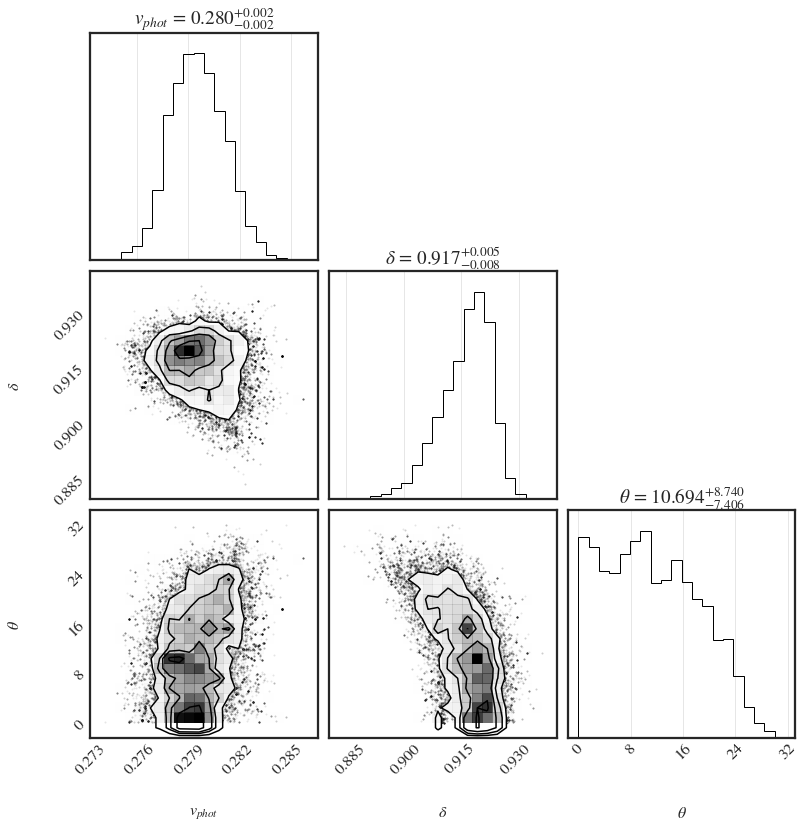

In [40]:
reset_plt(16,16)
flat2 = res6.flatchain
flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=3,ncols=3)
#ax = ax.flatten()
steady=5000
#reset_plt(16, 14)
corner.corner( np.array([flat['vphot'][steady:], flat['ratio_vel'][steady:], flat['inclin'][steady:]]).T, 
            labels=[r'$v_{phot}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 
ax[1][0].ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax[2][0].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax[2][1].ticklabel_format(axis="x", style="plain", scilimits=(0,0))

#plt.savefig('Pictures/Simulated_angle_cov_delta090_24x2500.png', dpi=300)

In [41]:
# 24x2500 excellent example of degeneracy between theta and delta 

#with open("./Data/1_Line_asphericity_angle_constraints_model_24x2500.pkl", 'wb') as outfile:
#    pickle.dump(res6, outfile)

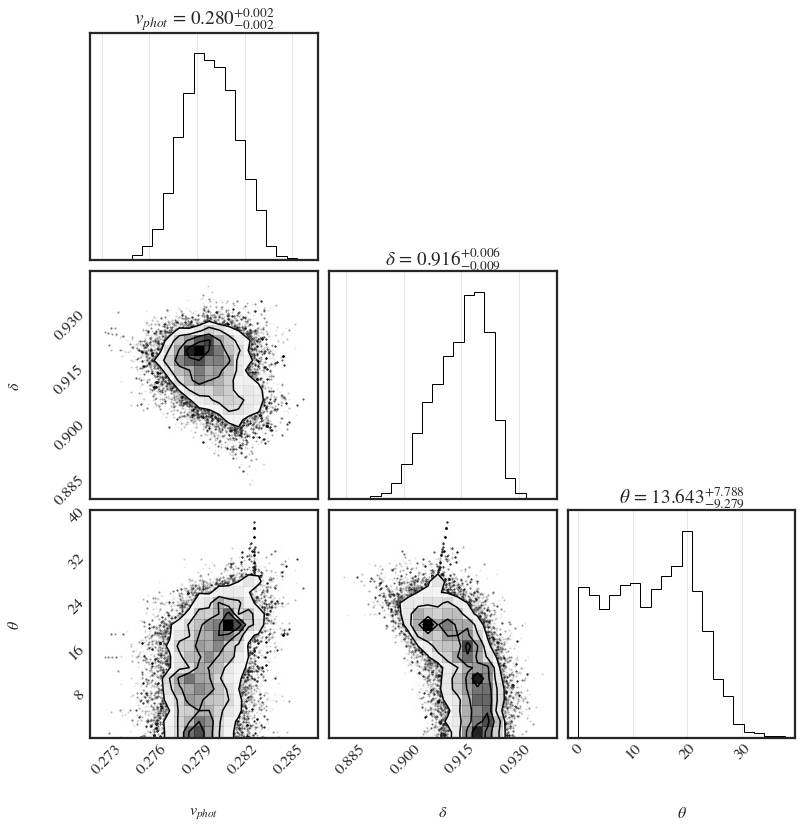

In [50]:
reset_plt(16,16)
flat2 = res6.flatchain
flat = res5.flatchain

steady=2000

vphot = np.append(flat['vphot'][steady:], flat2['vphot'][steady:])
ratio_vel = np.append(flat['ratio_vel'][steady:], flat2['ratio_vel'][steady:])
inclin = np.append(flat['inclin'][steady:], flat2['inclin'][steady:])

fig,ax = plt.subplots(figsize=(12,12),nrows=3,ncols=3)
#ax = ax.flatten()
#reset_plt(16, 14)
corner.corner( np.array([vphot, ratio_vel, inclin]).T, 
            labels=[r'$v_{phot}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 
ax[1][0].ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax[2][0].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax[2][1].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax[2][0].set_ylim(0,40), ax[2][1].set_ylim(0,40)

#plt.savefig('Pictures/Simulated_angle_cov_delta090_24x2500_1.png', dpi=300)

7.135529204473835 18.242766924280325 22.931322809894386


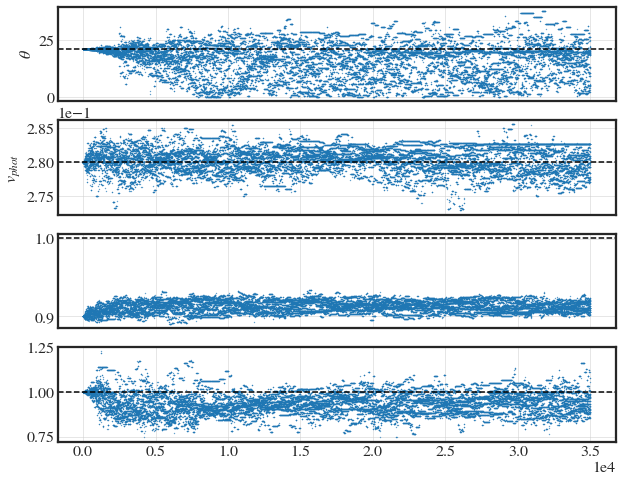

In [33]:
reset_plt(16,16)

flat2 = res5.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=4, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

ax[2].scatter(np.arange(len(flat2['inclin'])), flat2['ratio_vel'], s=0.1)
ax[2].axhline(1.001, ls='--', color='k')
#plt.ylim(0.75, 1.25)#ax[2].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{ratio}$')

ax[3].scatter(np.arange(len(flat2['inclin'])), flat2['occult'], s=0.1)
ax[3].axhline(1, ls='--', color='k')
#plt.xlim(0, 16*200*2)

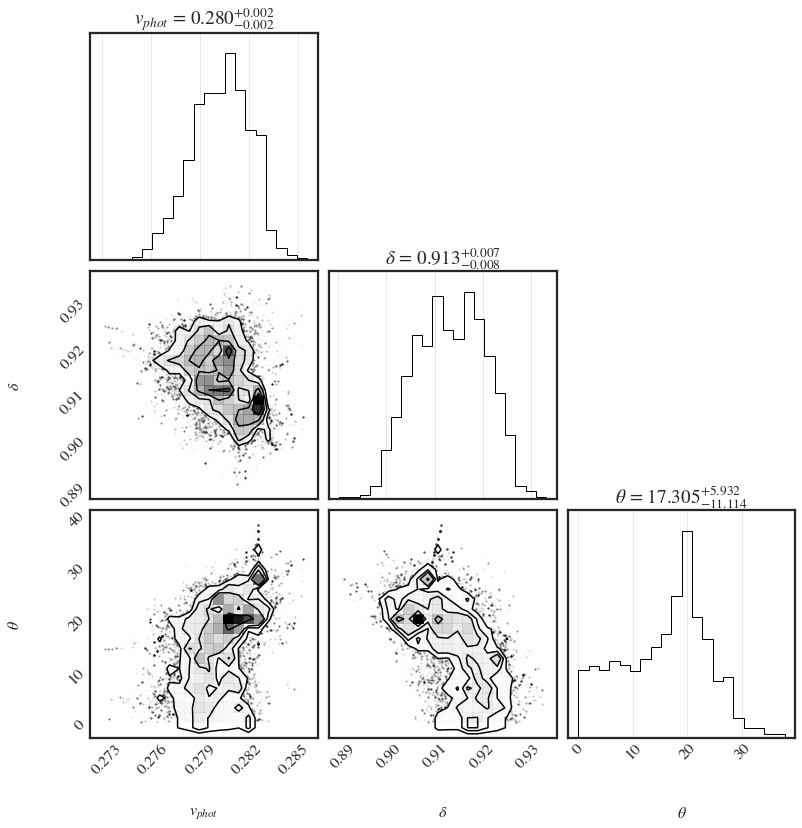

In [35]:
reset_plt(16,16)
flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=3,ncols=3)
#ax = ax.flatten()
steady=5000
#reset_plt(16, 14)
corner.corner( np.array([flat['vphot'][steady:], flat['ratio_vel'][steady:], flat['inclin'][steady:]]).T, 
            labels=[r'$v_{phot}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 
ax[1][0].ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax[2][0].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax[2][1].ticklabel_format(axis="x", style="plain", scilimits=(0,0))

#plt.savefig('Pictures/Simulated_angle_cov_delta110_12x5000.png', dpi=300)

32.24442981200223 63.3905257550622 79.57673460698807


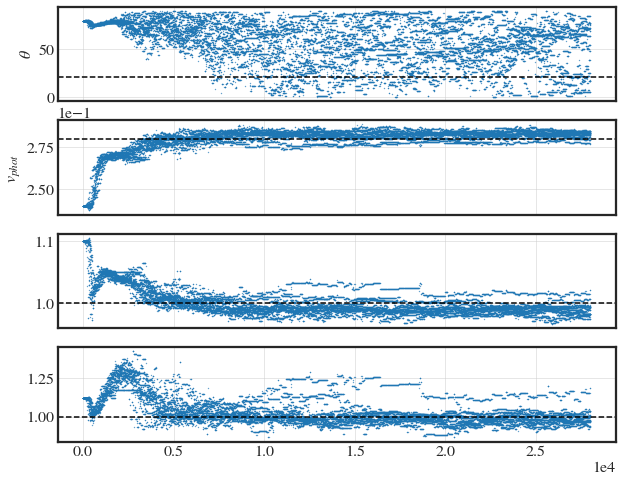

In [17]:
reset_plt(16,16)

flat2 = res4.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=4, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

ax[2].scatter(np.arange(len(flat2['inclin'])), flat2['ratio_vel'], s=0.1)
ax[2].axhline(1.001, ls='--', color='k')
#plt.ylim(0.75, 1.25)#ax[2].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{ratio}$')

ax[3].scatter(np.arange(len(flat2['inclin'])), flat2['occult'], s=0.1)
ax[3].axhline(1, ls='--', color='k')
#plt.xlim(0, 16*200*2)

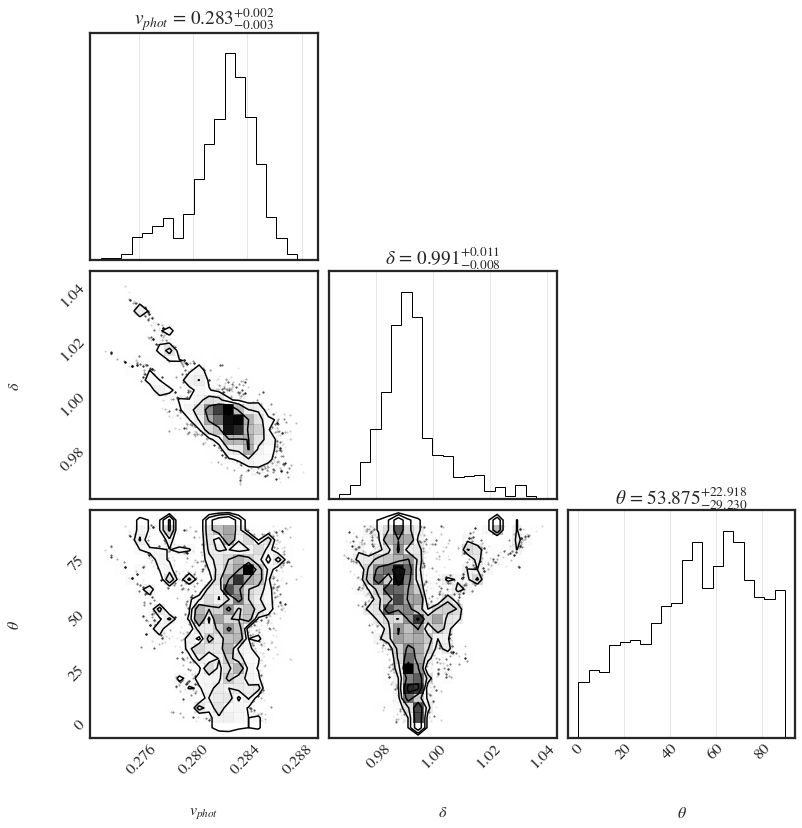

In [19]:
reset_plt(16,16)
flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=3,ncols=3)
#ax = ax.flatten()
steady=10000
#reset_plt(16, 14)
corner.corner( np.array([flat['vphot'][steady:], flat['ratio_vel'][steady:], flat['inclin'][steady:]]).T, 
            labels=[r'$v_{phot}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 
ax[1][0].ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax[2][0].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax[2][1].ticklabel_format(axis="x", style="plain", scilimits=(0,0))

#plt.savefig('Pictures/Simulated_angle_cov_delta110_12x5000.png', dpi=300)

0.9223081669750393 0.9557726816286746 1.1021088059128


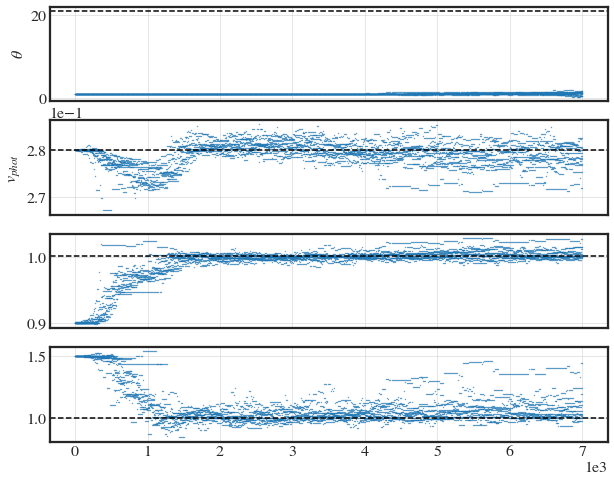

In [20]:
reset_plt(16,16)

flat2 = res4.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=4, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

ax[2].scatter(np.arange(len(flat2['inclin'])), flat2['ratio_vel'], s=0.1)
ax[2].axhline(1.001, ls='--', color='k')
#plt.ylim(0.75, 1.25)#ax[2].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{ratio}$')

ax[3].scatter(np.arange(len(flat2['inclin'])), flat2['occult'], s=0.1)
ax[3].axhline(1, ls='--', color='k')
#plt.xlim(0, 16*200*2)

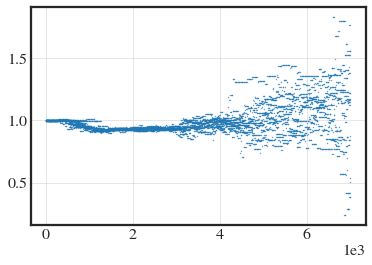

In [21]:
plt.scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)


In [24]:
# 12x5000 excellent example of degeneracy between theta and delta 

#with open("./Data/1_Line_asphericity_angle_constraints_model_12x5000.pkl", 'wb') as outfile:
#    pickle.dump(res3, outfile)

8.44728574455282 21.230229265423578 34.31893763685515


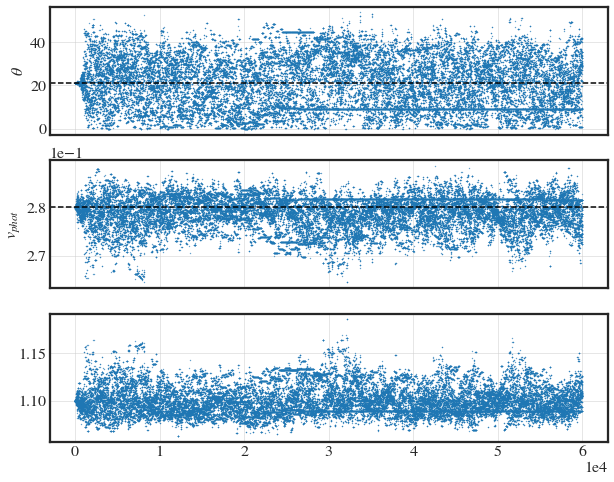

In [20]:
reset_plt(16,16)

flat2 = res3.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=3, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

ax[2].scatter(np.arange(len(flat2['inclin'])), flat2['ratio_vel'], s=0.1)
#plt.ylim(0.75, 1.25)#ax[2].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{ratio}$')

#plt.xlim(0, 16*200*2)

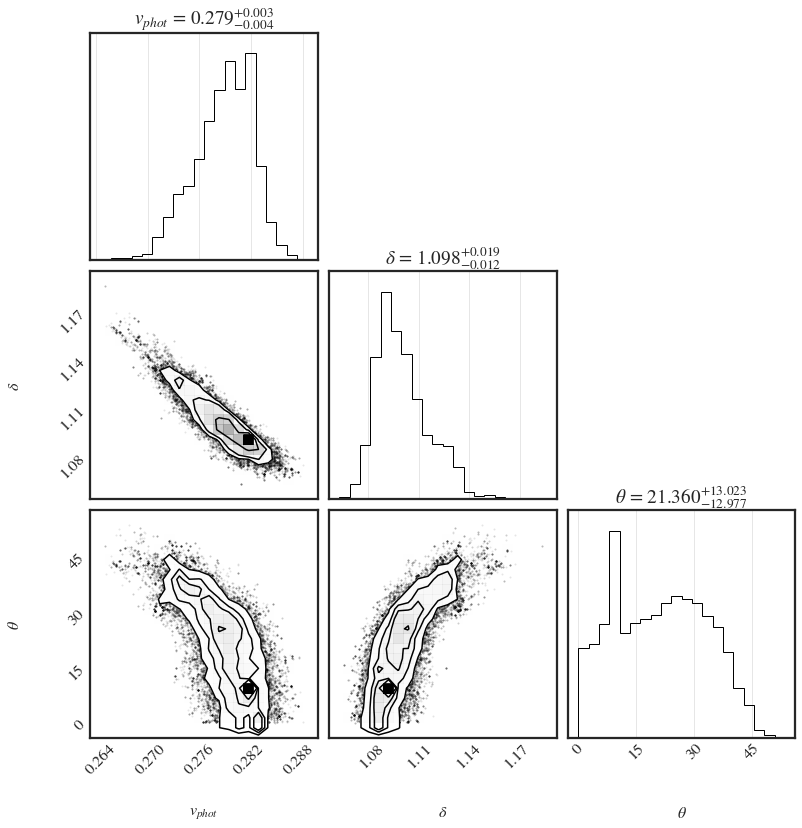

In [38]:
reset_plt(16,16)
flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=3,ncols=3)
#ax = ax.flatten()
steady=1000
#reset_plt(16, 14)
corner.corner( np.array([flat['vphot'][steady:], flat['ratio_vel'][steady:], flat['inclin'][steady:]]).T, 
            labels=[r'$v_{phot}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 
ax[1][0].ticklabel_format(axis="y", style="plain", scilimits=(0,0))
ax[2][0].ticklabel_format(axis="x", style="plain", scilimits=(0,0))
ax[2][1].ticklabel_format(axis="x", style="plain", scilimits=(0,0))

#plt.savefig('Pictures/Simulated_angle_cov_delta110_12x5000.png', dpi=300)

In [13]:
# Old run

#with open("./Data/1_Line_asphericity_angle_constraints_model_20x5000.pkl", 'wb') as outfile:
#    pickle.dump(res3, outfile)

17.85504620479654 22.685528143684223 28.199898733849828


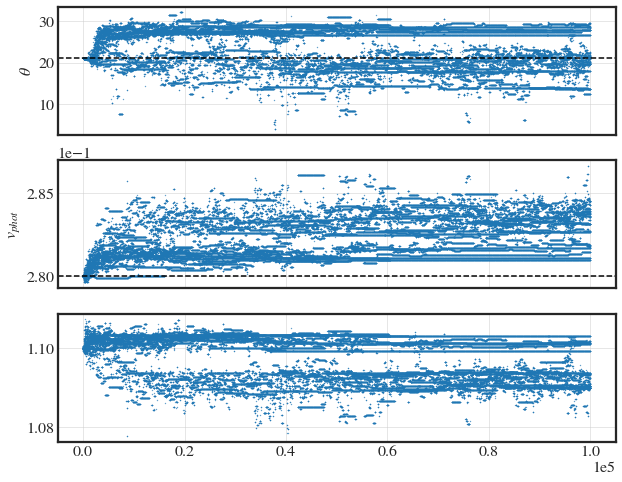

In [25]:
reset_plt(16,16)

flat2 = res3.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=3, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

ax[2].scatter(np.arange(len(flat2['inclin'])), flat2['ratio_vel'], s=0.1)
#plt.ylim(0.75, 1.25)#ax[2].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{ratio}$')

#plt.xlim(0, 16*200*2)

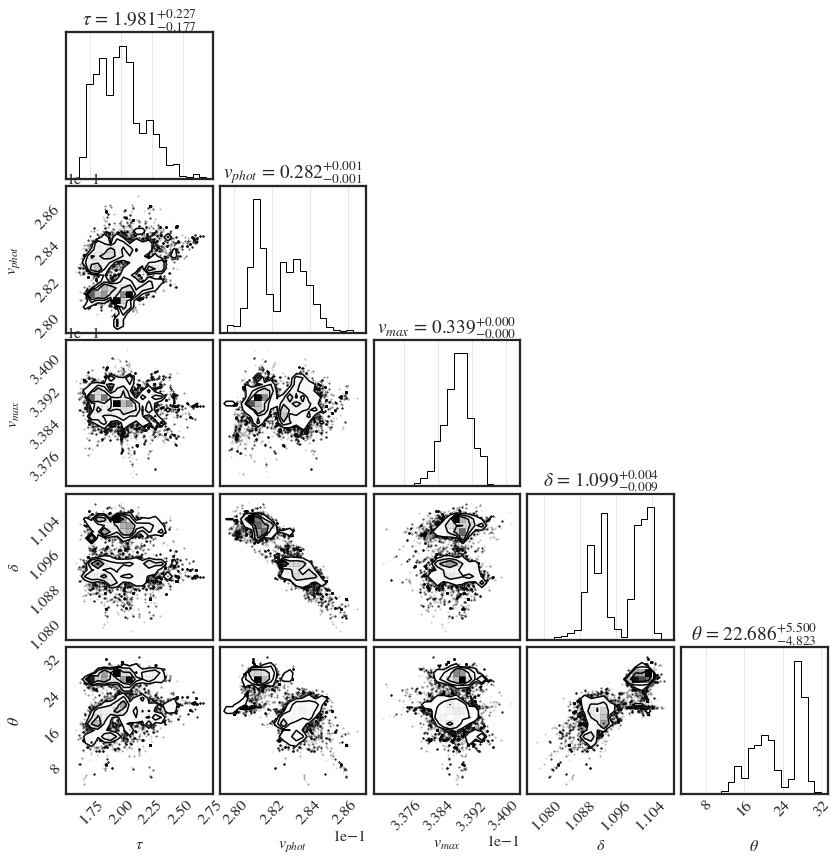

In [19]:
reset_plt(16,16)
flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
#reset_plt(16, 14)
corner.corner( np.array([flat['tau'], flat['vphot'], flat['vmax'], flat['ratio_vel'], flat['inclin']]).T, 
            labels=[r'$\tau$', r'$v_{phot}$', r'$v_{max}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov.png', dpi=300)

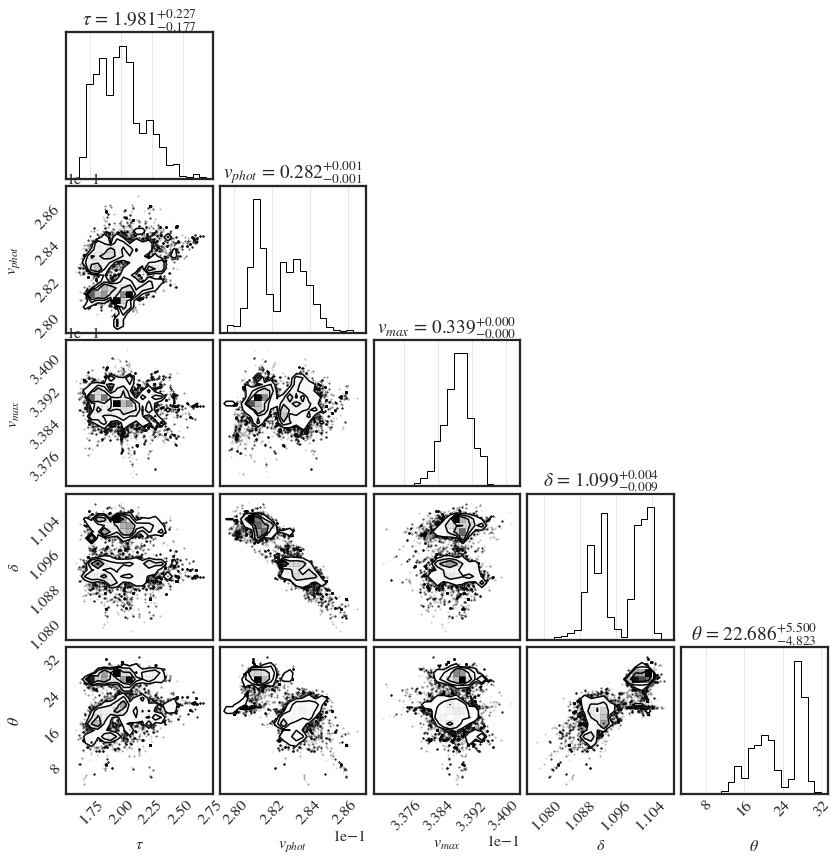

In [21]:
reset_plt(16,16)
flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
#reset_plt(16, 14)
corner.corner( np.array([flat['tau'], flat['vphot'], flat['vmax'], flat['ratio_vel'], flat['inclin']]).T, 
            labels=[r'$\tau$', r'$v_{phot}$', r'$v_{max}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov_2.png', dpi=300)

In [24]:
res3.flatchain

vphot      vmax       tau        ve  ratio_vel     inclin
0      0.279995  0.338013  1.999896  0.999935   1.100227  21.003523
1      0.279999  0.338011  2.000028  1.000032   1.100168  21.000337
2      0.280022  0.337989  1.999993  1.000047   1.099925  20.998929
3      0.280079  0.337971  1.999736  1.000201   1.100372  20.995571
4      0.279961  0.338013  2.000102  1.000055   1.100046  21.005195
...         ...       ...       ...       ...        ...        ...
99995  0.283646  0.338599  1.916626  5.102699   1.093366  19.659315
99996  0.284072  0.338696  2.477347  0.873850   1.090564  21.661651
99997  0.283166  0.339204  1.838821  1.808728   1.089950  13.753313
99998  0.281703  0.338924  1.861658  2.050590   1.101029  27.801712
99999  0.283407  0.338768  1.917876  2.478189   1.093395  22.068341

[100000 rows x 6 columns]

20.86581433660205 21.047120389858797 21.963308870123537


(0.0, 6400.0)

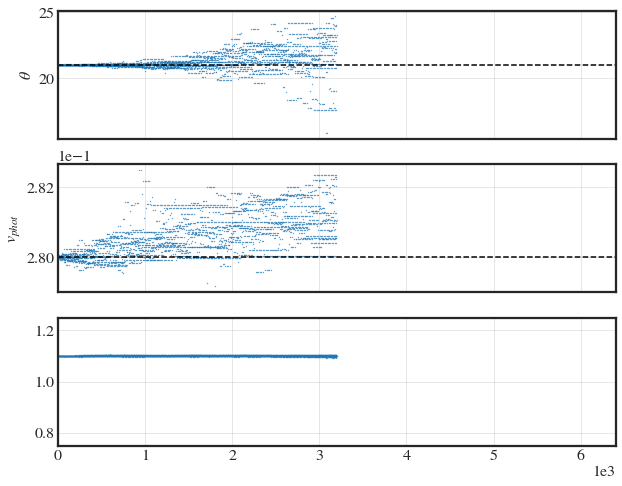

In [10]:
reset_plt(16,16)

flat2 = res3.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=3, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

ax[2].scatter(np.arange(len(flat2['inclin'])), flat2['ratio_vel'], s=0.1)
plt.ylim(0.75, 1.25)#ax[2].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{ratio}$')

plt.xlim(0, 16*200*2)

20.752054486311202 20.77849335273917 20.99092155776447


(0.0, 6400.0)

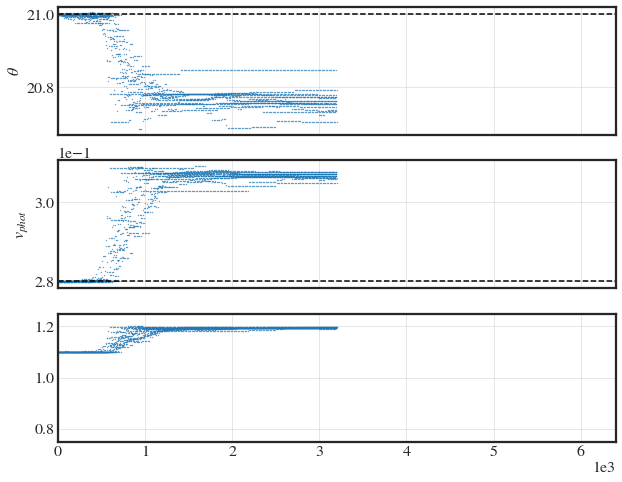

In [31]:
reset_plt(16,16)

flat2 = res3.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=3, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

ax[2].scatter(np.arange(len(flat2['inclin'])), flat2['ratio_vel'], s=0.1)
plt.ylim(0.75, 1.25)#ax[2].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{ratio}$')

plt.xlim(0, 16*200*2)

17.99016914887293 20.967509393705665 22.73349689361576


(<matplotlib.lines.Line2D at 0x2c4769cc790>, Text(0, 0.5, '$v_{phot}$'))

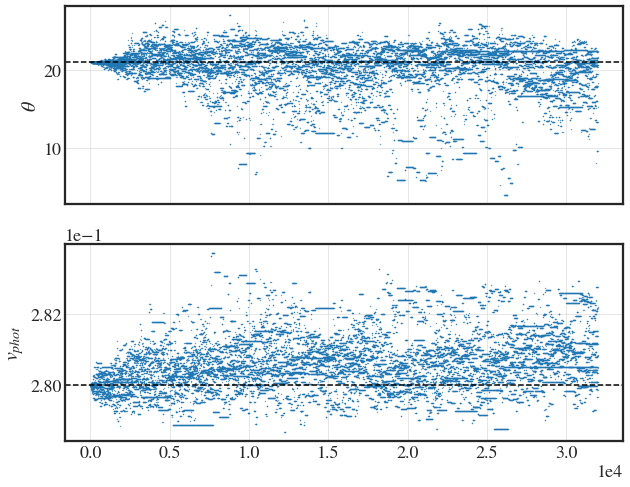

In [186]:
flat2 = res3.flatchain
fig,ax = plt.subplots(figsize=(10,8), nrows=2, sharex=True)
ax[0].scatter(np.arange(len(flat2['inclin'])), flat2['inclin'], s=0.1)
print(np.percentile(flat2['inclin'], 15.9), np.percentile(flat2['inclin'], 50), np.percentile(flat2['inclin'], 100-15.9) )
ax[0].axhline(21, color='k', ls='--'), ax[0].set_ylabel(r'$\theta$')

ax[1].scatter(np.arange(len(flat2['inclin'])), flat2['vphot'], s=0.1)
ax[1].axhline(0.28, color='k', ls='--'), ax[1].set_ylabel(r'$v_{phot}$')

[[1.         0.80647933]
 [0.80647933 1.        ]]


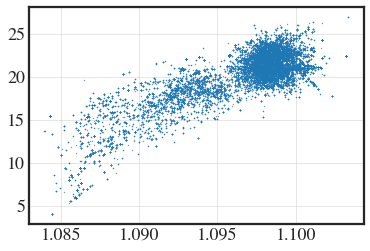

In [187]:
plt.scatter(flat2['ratio_vel'], flat2['inclin'], s=0.1)
print(np.corrcoef(flat2['ratio_vel'], flat2['inclin']))

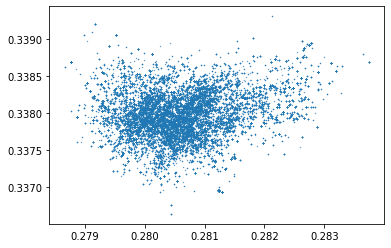

In [172]:
plt.scatter(flat2['vphot'], flat2['vmax'], s=0.1)


In [173]:
import corner
p

Parameters([('T', <Parameter 'T', value=5436 (fixed), bounds=[2500:7500]>), ('N', <Parameter 'N', value=1 (fixed), bounds=[-inf:inf]>), ('vphot', <Parameter 'vphot', value=0.28, bounds=[0:1]>), ('vmax', <Parameter 'vmax', value=0.338, bounds=[0:1]>), ('t0', <Parameter 't0', value=126000 (fixed), bounds=[-inf:inf]>), ('tau', <Parameter 'tau', value=5, bounds=[0:100]>), ('vref', <Parameter 'vref', value=0.0 (fixed), bounds=[0:1]>), ('ve', <Parameter 've', value=1, bounds=[0:10]>), ('occult', <Parameter 'occult', value=1 (fixed), bounds=[0:2]>), ('amp1', <Parameter 'amp1', value=0.28 (fixed), bounds=[0:1]>), ('amp2', <Parameter 'amp2', value=0.44 (fixed), bounds=[0:1]>), ('cen1', <Parameter 'cen1', value=1.55e-06 (fixed), bounds=[1.4e-06:1.7e-06]>), ('cen2', <Parameter 'cen2', value=2.02e-06 (fixed), bounds=[1.9e-06:2.2e-06]>), ('sig1', <Parameter 'sig1', value=5.8e-08 (fixed), bounds=[1e-08:3e-07]>), ('sig2', <Parameter 'sig2', value=8e-08 (fixed), bounds=[1e-08:3e-07]>), ('ratio_vel', <Parameter 'ratio_vel', value=1.1, bounds=[0.8:1.2]>), ('inclin', <Parameter 'inclin', value=21, bounds=[0:90]>)])

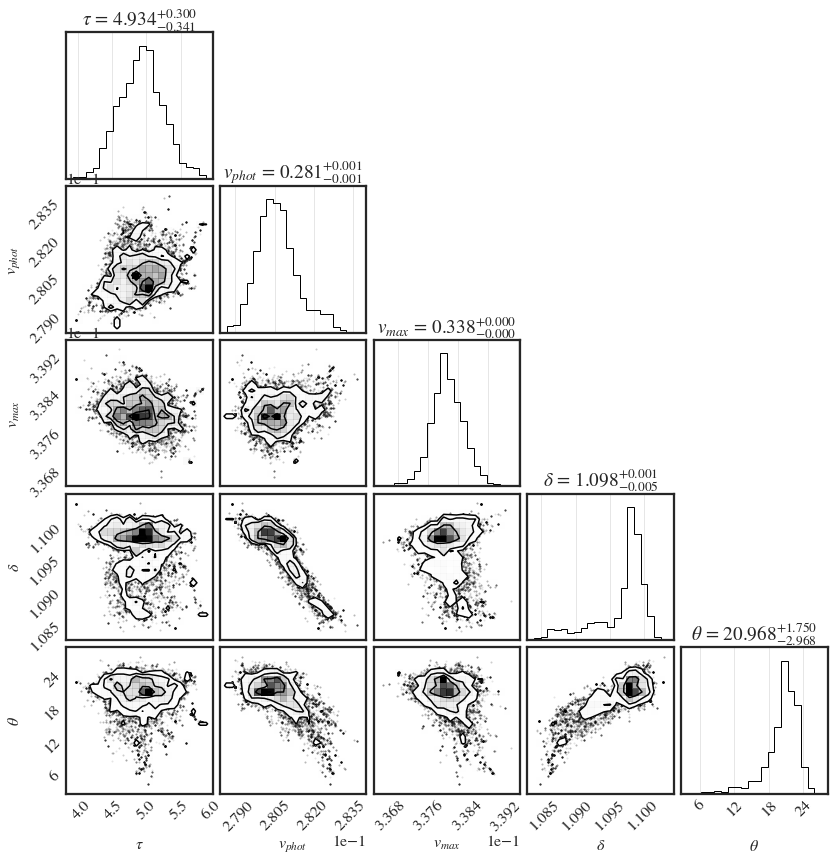

In [200]:
reset_plt(16,16)
#flat = flat2

fig,ax = plt.subplots(figsize=(12,12),nrows=5,ncols=5)
#ax = ax.flatten()
#reset_plt(16, 14)
corner.corner( np.array([flat['tau'], flat['vphot'], flat['vmax'], flat['ratio_vel'], flat['inclin']]).T, 
            labels=[r'$\tau$', r'$v_{phot}$', r'$v_{max}$', r'$\delta$', r'$\theta$'], show_titles=True, 
            fig=fig, title_fmt = '.3f'); 
#plt.tight_layout() 

#plt.savefig('Pictures/Simulated_angle_cov.png', dpi=300)

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,


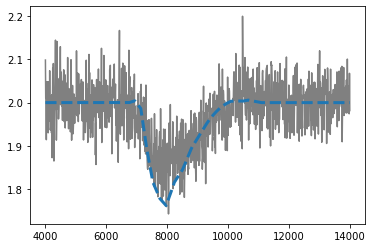

In [134]:
for i in [0]: 
    plt.plot(wl, flux, color='grey')
    
    p_new = flat2.sample()
    p_new['ve']=5
    p_new['tau']=1
    flux_fit_new = 2*residual_p_cygni_dataframe(p_new, wl2*1e-10)
    plt.plot(wl2, flux_fit_new, ls='--', label=r'$\theta=0$', linewidth=3)#, color='red')

In [133]:
p_new = flat2.sample()
p_new

vphot      vmax       tau        ve   occult  ratio_vel     inclin
7009  0.288959  0.252402  2.578421  0.013237  1.96661   1.047819  10.533793

In [ ]:
## Check how much we can increase rel_tolerance (not 1e30)

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: Integra

Text(0.5, 1.0, '1')

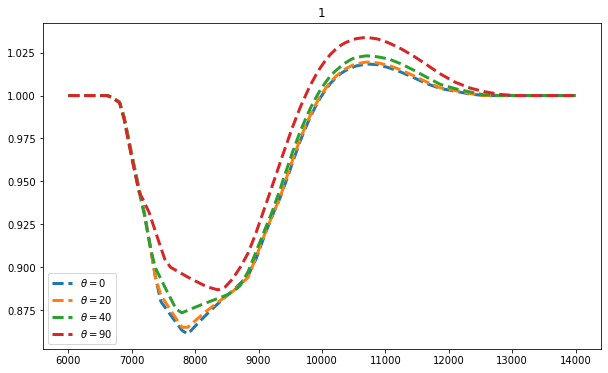

In [7]:
plt.figure(figsize=(10,6))

p['inclin'].value=0
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=0$', linewidth=3)#, color='red')

p['inclin'].value=20
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=20$', linewidth=3)#, color='red')

p['inclin'].value=40
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=40$', linewidth=3)#, color='red')

p['inclin'].value=90
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=90$', linewidth=3)#, color='red')

plt.legend()
plt.title('1')

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

Text(0.5, 1.0, '1e10')

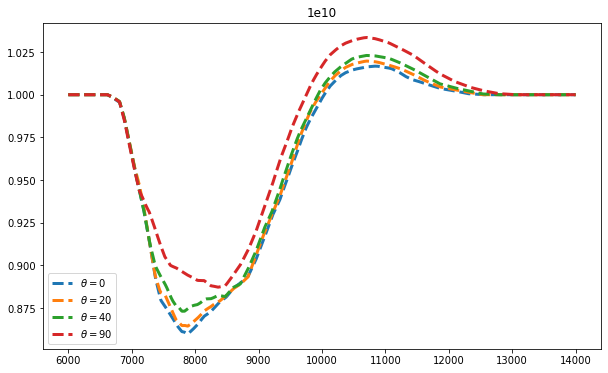

In [12]:
plt.figure(figsize=(10,6))

p['inclin'].value=0
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=0$', linewidth=3)#, color='red')

p['inclin'].value=20
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=20$', linewidth=3)#, color='red')

p['inclin'].value=40
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=40$', linewidth=3)#, color='red')

p['inclin'].value=90
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=90$', linewidth=3)#, color='red')

plt.legend()
plt.title('1e10')

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

Text(0.5, 1.0, '1e20')

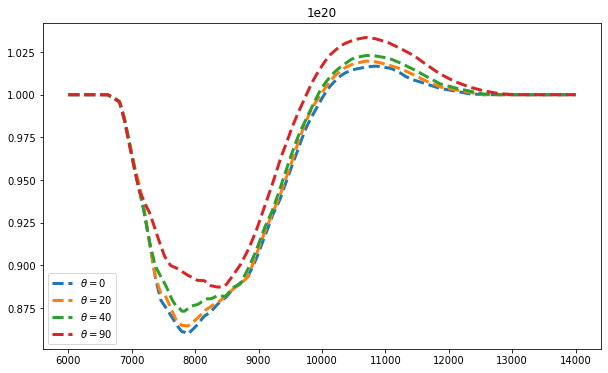

In [6]:
plt.figure(figsize=(10,6))

p['inclin'].value=0
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=0$', linewidth=3)#, color='red')

p['inclin'].value=20
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=20$', linewidth=3)#, color='red')

p['inclin'].value=40
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=40$', linewidth=3)#, color='red')

p['inclin'].value=90
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=90$', linewidth=3)#, color='red')

plt.legend()
plt.title('1e20')

C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  quad_r = quad(f, low, high, args=args, full_output=self.full_output,
C:\Users\asnep\Anaconda3\lib\site-packages\scipy\integrate\quadpack.py:879: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably g

Text(0.5, 1.0, '1e25')

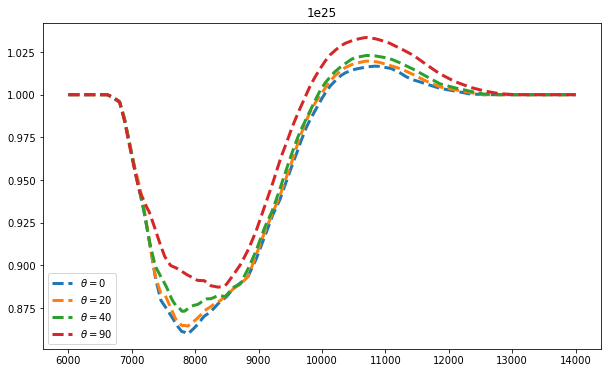

In [5]:
plt.figure(figsize=(10,6))

p['inclin'].value=0
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=0$', linewidth=3)#, color='red')

p['inclin'].value=20
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=20$', linewidth=3)#, color='red')

p['inclin'].value=40
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=40$', linewidth=3)#, color='red')

p['inclin'].value=90
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=90$', linewidth=3)#, color='red')

plt.legend()
plt.title('1e25')

Text(0.5, 1.0, '1e30')

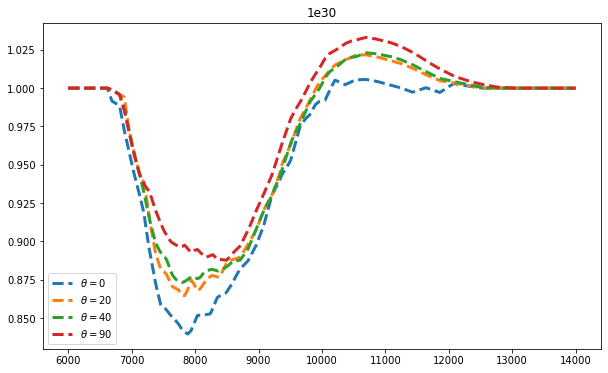

In [5]:
plt.figure(figsize=(10,6))

p['inclin'].value=0
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=0$', linewidth=3)#, color='red')

p['inclin'].value=20
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=20$', linewidth=3)#, color='red')

p['inclin'].value=40
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=40$', linewidth=3)#, color='red')

p['inclin'].value=90
flux_fit2 = residual_p_cygni(p, wl2*1e-10)
plt.plot(wl2, flux_fit2, ls='--', label=r'$\theta=90$', linewidth=3)#, color='red')

plt.legend()
plt.title('1e30')